# Исследование оттока клиентов

**Цель проекта:** научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента; сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства; проанализировать основные признаки, наиболее сильно влияющие на отток; сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами: 1) выделить целевые группы клиентов; 2) предложить меры по снижению оттока;

## Ознакомление с данными

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import itertools

pd.set_option('display.max_colwidth', 150)
pd.set_option('display.float_format', '{:,.3f}'.format)

In [2]:
# загружаем файл с данными
try:
    gym_churn = pd.read_csv("gym_churn.csv", sep=',')
except:
    gym_churn = pd.read_csv("/datasets/gym_churn.csv", sep=',')

In [3]:
# посмотрим на данные поближе
def info(data):
    print('\033[1m' + 'Общая информация о датасете:' + '\033[0m')
    data.info()
    print('*'*50)
    print('\033[1m' + 'Статистические характеристики:' + '\033[0m')
    display(data.describe(include='all'))
    print('*'*50)
    print('\033[1m' + 'Данные в датасете:' + '\033[0m')
    display(data)
    print('*'*50)
    display('Количество дубликатов:', data.duplicated().sum())
    display('Количество пропусков:', pd.concat([data.isna().sum(), data.isna().mean()], axis=1)\
    .rename(columns={0:'кол-во', 1:'доля'})\
    .style.format({'кол-во':'{:.0f}', 'доля':'{:.2%}'}))
info(gym_churn)

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total  

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,"4,000.000","4,000.000","4,000.000","4,000.000","4,000.000","4,000.000","4,000.000","4,000.000","4,000.000","4,000.000","4,000.000","4,000.000","4,000.000","4,000.000"
mean,0.510,0.845,0.487,0.308,0.903,4.681,0.412,29.184,146.944,4.323,3.725,1.879,1.767,0.265
std,0.500,0.362,0.500,0.462,0.295,4.550,0.492,3.258,96.356,4.191,3.749,0.972,1.053,0.442
min,0.000,0.000,0.000,0.000,0.000,1.000,0.000,18.000,0.148,1.000,0.000,0.000,0.000,0.000
25%,0.000,1.000,0.000,0.000,1.000,1.000,0.000,27.000,68.869,1.000,1.000,1.181,0.963,0.000
50%,1.000,1.000,0.000,0.000,1.000,1.000,0.000,29.000,136.220,1.000,3.000,1.833,1.720,0.000
75%,1.000,1.000,1.000,1.000,1.000,6.000,1.000,31.000,210.950,6.000,5.000,2.536,2.510,1.000
max,1.000,1.000,1.000,1.000,1.000,12.000,1.000,41.000,552.591,12.000,31.000,6.024,6.147,1.000


**************************************************
Данные в датасете:


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227,5.000,3,0.020,0.000,0
1,0,1,0,0,1,12,1,31,113.203,12.000,7,1.923,1.910,0
2,0,1,1,0,1,1,0,28,129.448,1.000,2,1.859,1.737,0
3,0,1,1,1,1,12,1,33,62.670,12.000,2,3.206,3.357,0
4,1,1,1,1,1,1,0,26,198.362,1.000,3,1.114,1.120,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.406,12.000,8,2.284,2.349,0
3996,0,1,0,0,1,1,1,29,68.884,1.000,1,1.277,0.293,1
3997,1,1,1,1,1,12,0,28,78.251,11.000,2,2.786,2.831,0
3998,0,1,1,1,1,6,0,32,61.913,5.000,3,1.630,1.596,0


**************************************************


'Количество дубликатов:'

0

'Количество пропусков:'

,кол-во,доля
gender,0,0.00%
Near_Location,0,0.00%
Partner,0,0.00%
Promo_friends,0,0.00%
Phone,0,0.00%
Contract_period,0,0.00%
Group_visits,0,0.00%
Age,0,0.00%
Avg_additional_charges_total,0,0.00%
Month_to_end_contract,0,0.00%


**Вывод:** 

В датасете у нас 4000 анкет посетителей и 14 колонок с признаками и целевой переменной. Дубликатов нет.

Набор данных включает следующие поля:
Данные клиента за предыдущий до проверки факта оттока месяц:
- `'gender'` — пол;
- `'Near_Location'` — проживание или работа в районе, где находится фитнес-центр;
- `'Partner'` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- `'Phone'` — наличие контактного телефона;
- `'Age'` — возраст;
- `'Lifetime'` — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- `'Contract_period'` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- `'Month_to_end_contract'` — срок до окончания текущего действующего абонемента (в месяцах);
- `'Group_visits'` — факт посещения групповых занятий;
- `'Avg_class_frequency_total'` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `'Avg_class_frequency_current_month'` — средняя частота посещений в неделю за предыдущий месяц;
- `'Avg_additional_charges_total'` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- `'Churn'` — факт оттока в текущем месяце.

Данные чистые, пропусков нет, категориальные переменные, такие как пол, проживание в районе фитнес-центра и т.д.уже переведены в числовые значения, что облегчает анализ и пригодится для построения моделей.

Конкретно по данным можно сказать следующее:
- Распределение по полу примерно одинаково
- Большинство клиентов (85%) живет или работает рядом с фитнес-клубом
- Примерно половина клиентов являются сотрудниками партнерских организаций
- Около 30% клиентов пришли по программе "Приведи друга"
- Известны мобильные номера примерно 90% клиентов
- Средняя длительность абонементов клиентов - 4.6 месяцев
- Около 40% клиентов посещают групповые занятия
- Средний возраст клиентов 29 лет
- Средняя частота посещений за все время - 1.87 раз в неделю
- Средняя частота посещений за последний месяц - 1.76 раз в неделю
- Доля оттока - 27%

## Исследовательский анализ данных(EDA)

### Средние значения в группах(те кто ушел и кто остался)

Посмотрим в абсолютных числах сколько из 4000тысяч клиентов ушло, а сколько осталось.

In [4]:
display(gym_churn.groupby('Churn')['Churn'].agg('count'))

Churn
0    2939
1    1061
Name: Churn, dtype: int64

1061 посетитель попал в отток, это достаточно много.

In [5]:
gym_churn.groupby('Churn').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510,0.873,0.534,0.354,0.904,5.747,0.464,29.977,158.446,5.283,4.712,2.025,2.028
1,0.511,0.768,0.355,0.184,0.903,1.729,0.269,26.990,115.083,1.663,0.991,1.475,1.045


После разделения клиентов по признаку оттока можно сказать следующее:
- Распределение по полу не отличается
- Ближе живущие или работающие клиенты немного реже попадают в отток.
- Сотрудники компаний-партнеров реже перестают посещать фитнесс-клуб чем остальные клиенты
- Клиенты, пришедшие по акции "Приведи друга" в два раза реже уходят в отток
- Наличие мобильного номера клиента не отличается в группах
- Средняя длительность договора полне логично больше у оставшихся пользователей, у большей части клиентов в оттоке срок договора составляет 1 месяц (скорее это говорит о том, что чаще клиенты заключают договор на 1 месяц).
- Интересный момент: среди ушедших средний лайфтайм с момента первого обращения в фитнес-центр - меньше месяца. Значит, есть проблемы с удержанием, клиенты не смогли заинтересоваться и спустя месяц ушли.
- Оставшиеся пользователи чаще ходят на групповые занятия.
- Оставшееся время до окончания срока действия договора логично больше у оставшихся клиентов.
- У клиентов в оттоке меньше среднее количество посещений в неделю за всё время
- Количество посещений в предыдущий месяц в два раза ниже у клиентов в оттоке

<div class="alert alert-success">
<b>👍 Успех:</b> Хорошо подмечена разница между группами оставшихся и ушедших клиентов
</div>

### Гистограммы

Построим столбчатые диаграммы признаков для тех, кто ушел(отток) и тех, кто остался.

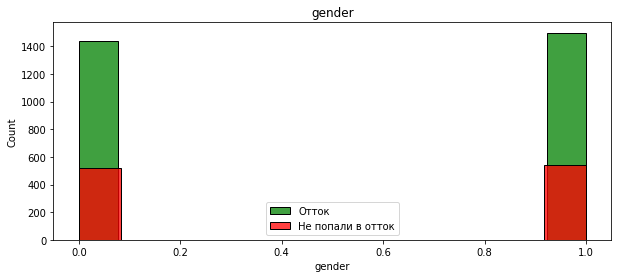

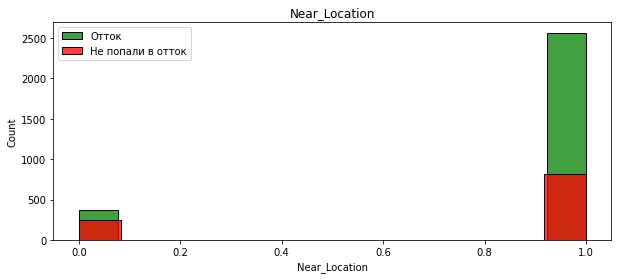

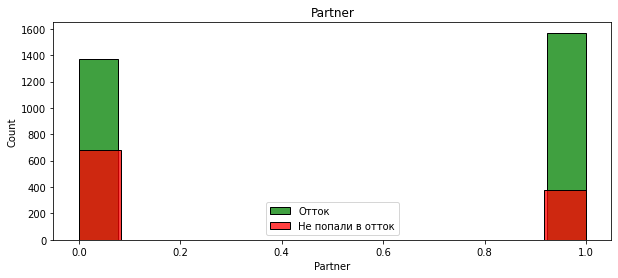

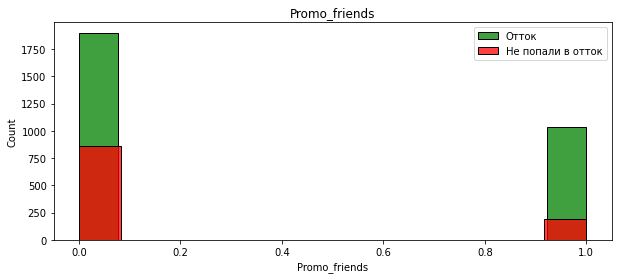

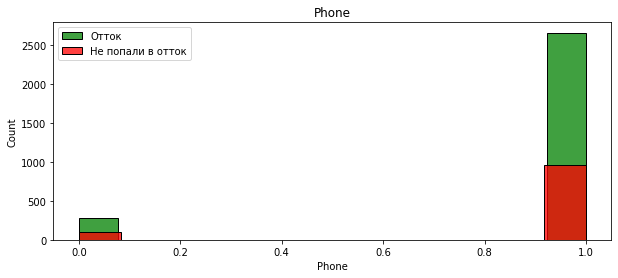

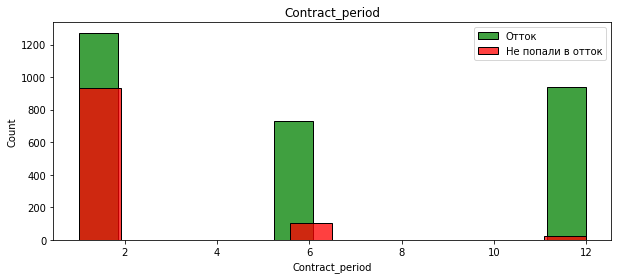

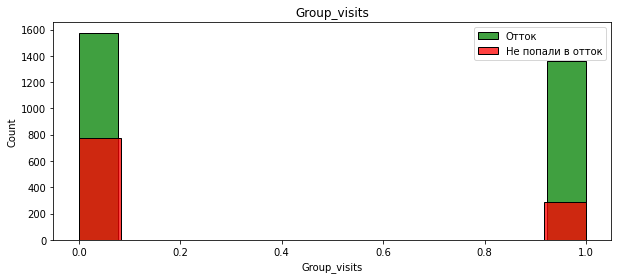

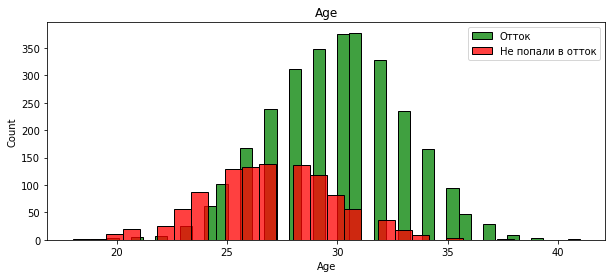

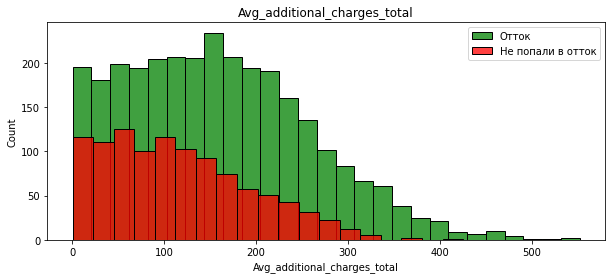

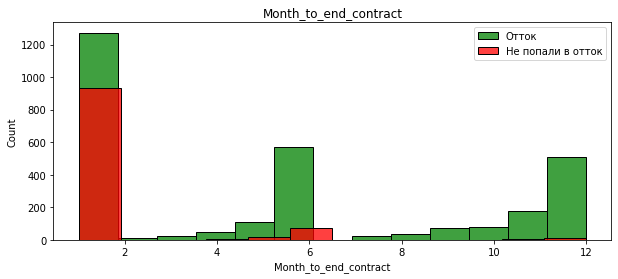

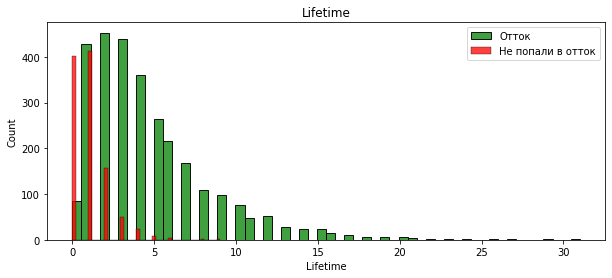

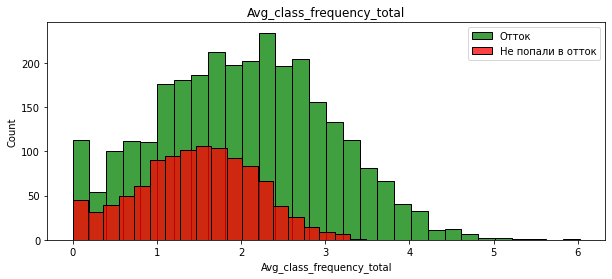

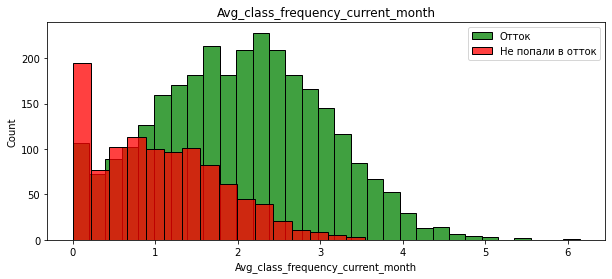

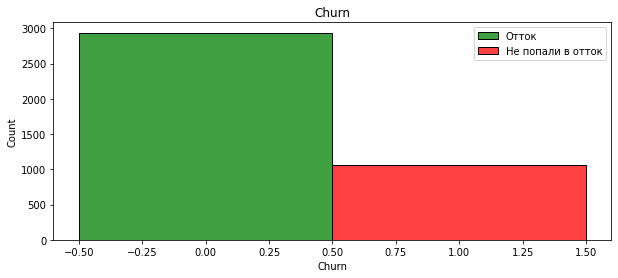

In [6]:
for col in  gym_churn.columns:
    plt.figure(figsize=(10,4)) 
    plt.title(col)
    sns.histplot(gym_churn.query('Churn==0')[col], color='green')
    sns.histplot(gym_churn.query('Churn==1')[col], color='red')
    plt.legend(['Отток', 'Не попали в отток'])
    plt.show()

### Матрица корреляций и тепловая карта

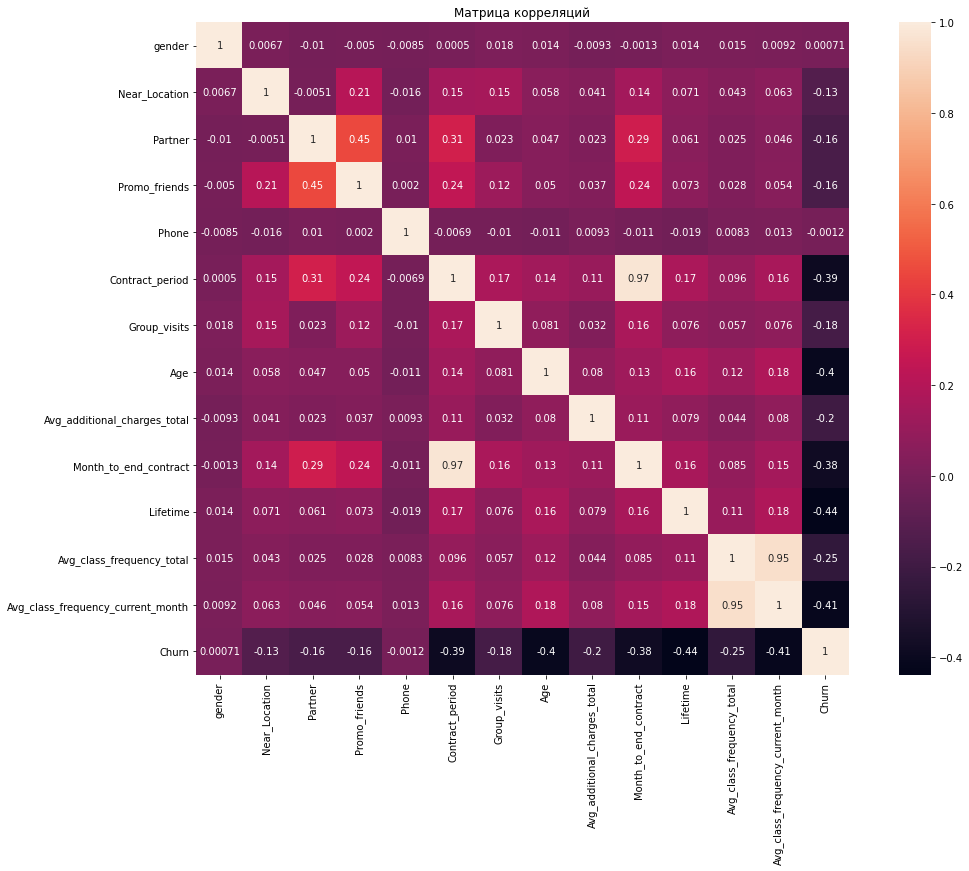

In [7]:
#построим и отрисуем матрицу корреляций
cm = gym_churn.corr() 
plt.figure(figsize=(18,12))
sns.heatmap(cm, annot=True, square=True)
plt.title('Матрица корреляций')
plt.show();

**Вывод:** нет явной зависимости факта оттока от признаков, но есть 2 пары мультиколлинеарных признаков - `Month_to_end_contract` - `Сontract_period` и `Avg_class_frequency_total` - `Avg_class_frequency_current_month`

## Строим модель прогнозирования оттока пользователей

### Разбиваем данные на обучающую и валидационную выборки

In [8]:
#разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = gym_churn.drop('Churn', axis=1) 
y = gym_churn['Churn'] 

In [9]:
#разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

### Обучаем модель логистической регрессией и делаем прогноз

In [10]:
# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train) # обучаем scaler и одновременно трансформируем матрицу для обучающей выборки

# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

In [11]:
# задаем алгоритм для нашей модели
model = LogisticRegression(solver='liblinear', random_state=0)

# обучаем модель
model = model.fit(X_train_st, y_train)

# делаем прогнозы
lr_pred = model.predict(X_test_st) 
lr_prob = model.predict_proba(X_test_st)[:,1] 

### Обучаем модель случайным лесом и делаем прогноз

In [12]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 

# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_pred = rf_model.predict(X_test_st)
rf_prob = rf_model.predict_proba(X_test_st)[:, 1]

### Оцениваем метрики для обеих моделей

In [13]:
# определим функцию, которая будет выводить наши метрики
def print_metrics(y_true, y_pred, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [14]:
print_metrics(y_test, lr_pred, title='Метрики для модели логистической регрессии')

Метрики для модели логистической регрессии
	Accuracy: 0.94
	Precision: 0.90
	Recall: 0.85


In [15]:
print_metrics(y_test, rf_pred, title='Метрики для модели логистической регрессии')

Метрики для модели логистической регрессии
	Accuracy: 0.92
	Precision: 0.88
	Recall: 0.83


**Вывод:** Модель логистической регрессии показала себя лучше на основании метрик.

## Кластеризация пользователей

### Стандартизация и отрисовка дендрограммы

Проведем стандартизацию данных, построим матрицу расстояний и нарисуем дендрограмму.

In [16]:
# стандартизируем данные
sc = StandardScaler()
x_sc = sc.fit_transform(gym_churn)

In [17]:
# строим матрицу расстояний
linked = linkage(x_sc, method = 'ward') 

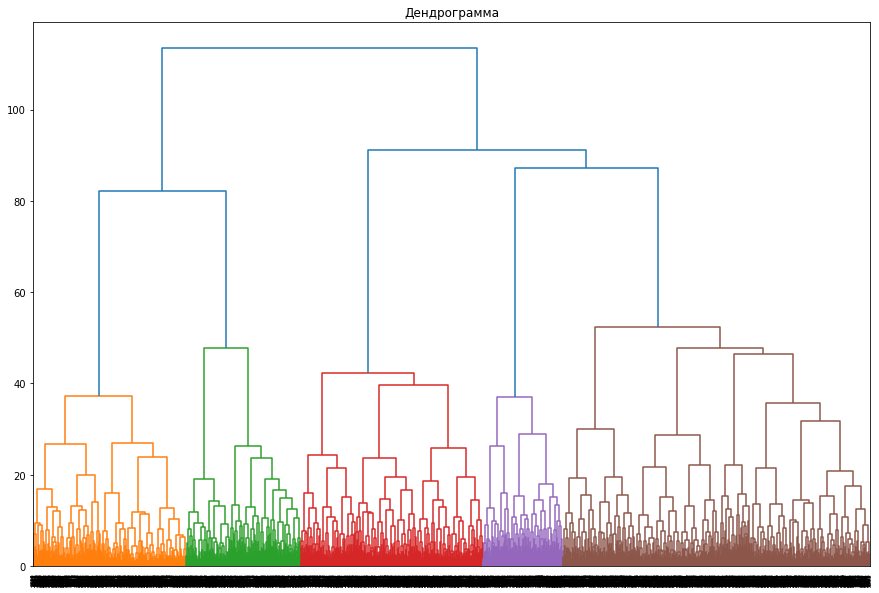

In [18]:
# строим дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма')
plt.show() 

Явно можно выделить 5 больших кластеров по дендрограмме.

### Обучение и прогноз кластеров на основании алгоритма K-Means

In [19]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)

# прогнозируем кластеры для наблюдений
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
gym_churn['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
display(gym_churn.groupby('cluster_km').mean())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster_km,,,,,,,,,,,,,,
0,0.504,0.000,0.460,0.075,0.917,2.070,0.211,28.522,132.741,1.950,2.757,1.707,1.516,0.450
1,0.493,0.936,0.764,0.535,0.919,10.447,0.516,29.962,161.854,9.477,4.833,2.788,2.787,0.008
2,0.508,1.000,0.324,0.213,0.904,1.547,0.287,26.927,113.173,1.501,1.032,1.450,1.038,0.961
3,0.521,0.997,0.282,0.208,0.904,1.882,0.453,30.237,157.989,1.795,4.924,2.203,2.207,0.003
4,0.519,0.968,0.744,0.526,0.874,8.859,0.535,29.728,162.907,8.156,4.411,0.958,0.944,0.025


Сразу бросается в глаза кластер с индексом 2, где отток клиентов практически 96% в этом кластере наименьшая выручка с клиентов от дополнительных услуг и самый маленький лайфтайм. Если говорить о том, какой кластер "самый надежный", то это кластер с индексом 3, где отток сосставляет всего 0,3%. Он характеризуется самым высоким лайфтаймом, более высоким средним возрастом посетителей, при этом всего 28% клиентов(самый малый процент среди кластеров) является сотрудниками компании-партнера.

### Распределение признаков для кластеров

Используем гистограммы, чтобы посмотреть распределение признаков для кластеров.

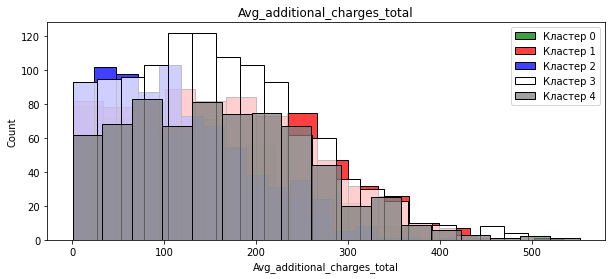

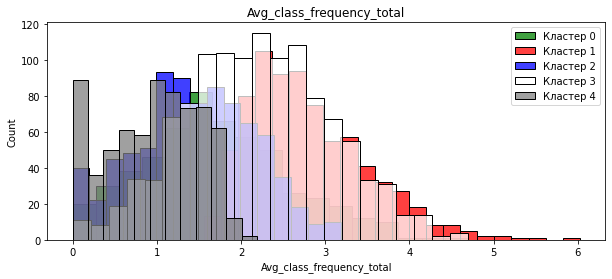

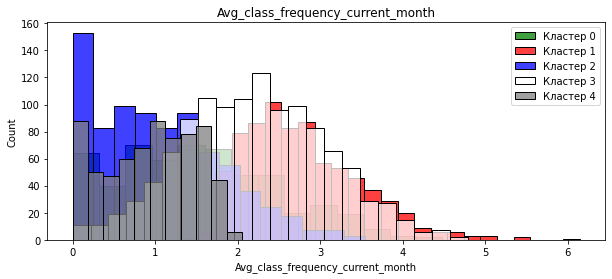

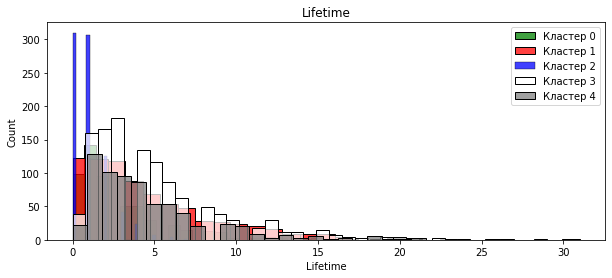

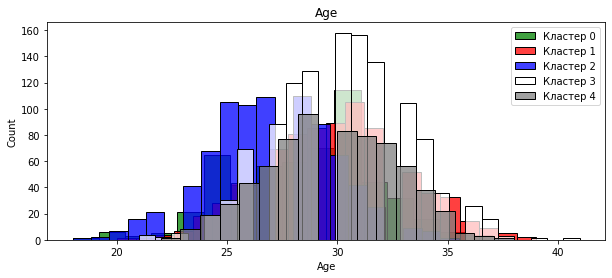

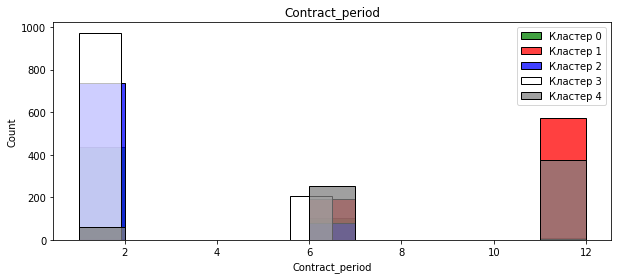

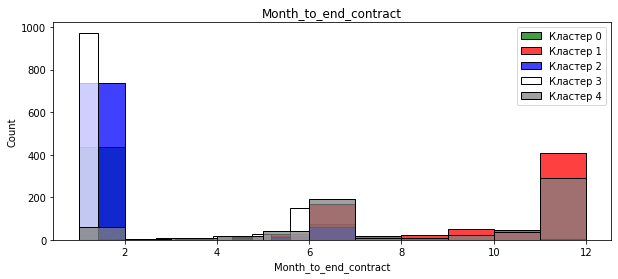

In [36]:
cluster_0 = gym_churn.query('cluster_km==0')
cluster_1 = gym_churn.query('cluster_km==1')
cluster_2 = gym_churn.query('cluster_km==2')
cluster_3 = gym_churn.query('cluster_km==3')
cluster_4 = gym_churn.query('cluster_km==4')

histplot_columns = ['Avg_additional_charges_total', 'Avg_class_frequency_total', 
                    'Avg_class_frequency_current_month', 'Lifetime', 'Age', 
                    'Contract_period', 'Month_to_end_contract']
for col in histplot_columns:
    plt.figure(figsize=(10,4))
    plt.title(col)
    sns.histplot(cluster_0[col], color='green')
    sns.histplot(cluster_1[col], color='red')
    sns.histplot(cluster_2[col], color='blue')
    sns.histplot(cluster_3[col], color='white')
    sns.histplot(cluster_4[col], color='grey')
    plt.legend(['Кластер 0', 'Кластер 1', 'Кластер 2', 'Кластер 3', 'Кластер 4'])
    plt.show()

Гистограммы подтверждают наши выводы, у кластера 2 наблюдаем что лайфтайм сосредоточен на значениях 0-2 месяца и малые затраты на дополнительные услуги.

## Общий вывод

Было исследовано **4000** анкет посетителей фитнес центра для каждого из которых определено **14** характеристик(целевая переменная и тринадцать признаков). 
После группировки анкет по факту оттока выявлены основные особенности клиентов, но нет явной зависимости факта оттока от признаков.
На основании этих данных была построено две прогнозных модели, одна из которых - **логистическая регрессия** на метриках показала лучшие результаты.
С помощью алгоритма `K-Means` данные были разделены на **5** кластеров и выявлен кластре, в котором клиенты наиболее склонны к оттоку. В этом кластере наименьшая выручка с клиентов от дополнительных услуг и самый маленький лайфтайм. Если говорить о том, какой кластер "самый надежный", то это кластер, где отток сосставляет всего **0,3%**. Он характеризуется самым высоким лайфтаймом, более высоким средним возрастом посетителей, при этом всего **28%** клиентов(самый малый процент среди кластеров) является сотрудниками компании-партнера.

**Рекомендации:**
- удержание колеблющихся, за счет скидок на групповые занятия и комплиментов (например,скидка на вторую покупку в неделю на дополнительные услуги)
- стимуляция за счет предложений продления абонементов до года со скидками
- стимуляция начинающих посещать не реже **1** раза в неделю(например смс-напомнинание о тренировке)
- акции и розыгрыши, направленые на знакомство клиентов с дополнительными услугами(кафе, косметический и массажный салоны).